(3, 128, 128, 3)


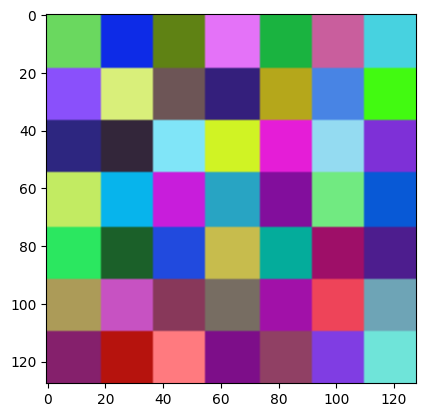

In [49]:
# image mapping
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

src = np.random.randint(0,256,(7,7,3),dtype=np.uint8)
src = cv2.resize(src,(128,128),interpolation=cv2.INTER_NEAREST)
plt.imshow(src)
src = np.repeat(src.reshape(1,*src.shape),3,0)
print(src.shape)

In [51]:
def get_inv_FCG_mapping(nr,pmax,p0,c_gaze):
    """
    Returns inverse mapping of Foveal Cartesian Geometry.
    This inverse mapping is required for the cv2::remap to perform foveation
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
        
    Returns
        X, Y : ndarray
        inverse mapping X and Y. arrays are the same size with the foveated image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x' and y' to use np
    dx = np.arange(0,(p0+nr)*2+1)
    dy = np.arange(0,(p0+nr)*2+1)
    X_out, Y_out = np.meshgrid(dx,dy) # _out is equal to ' in Table 1.
    # inverse mapping algorithm as in Table 1.
    X_out = X_out - fcx
    Y_out = Y_out - fcy
    R = np.max(np.stack((np.abs(X_out),np.abs(Y_out))),axis=0)
    # In the paper, case where r <= p0 is defined seperately.
    # However, it is not necessary if XI = 0 for XI < 0
    XI = np.clip(R-p0,0,nr)
    X = np.floor(X_out*delta_p(XI)+x0).astype(np.float32)
    Y = np.floor(Y_out*delta_p(XI)+y0).astype(np.float32)
    return X,Y

def get_FCG_mapping(nr,pmax,p0,c_gaze,src_size):
    """
    Returns the mapping of Foveal Cartesian Geometry.
    This mapping is required for the cv2::remap to perform recovery from foveated image
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
    src_size : (Integer,Integer)
        (height, width) of the src image.
        
    Returns
        X_out, Y_out : ndarray
        The mapping X and Y. arrays are the same size with the src image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    h, w = src_size
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x and y to use np
    dx = np.arange(0,w)
    dy = np.arange(0,h)
    X, Y = np.meshgrid(dx,dy)
    # mapping algorithm as in Table 1.
    X = X-x0
    Y = Y-y0
    # distance map
    P = np.max(np.stack((np.abs(X),np.abs(Y))),axis=0)
    # if-else clause can be defined simultaneously if 
    # (p = p0 for p <= p0) and (p = pmax for p >= pmax)
    P = np.clip(P,p0,pmax)
    XI = np.floor(np.log(P/p0)/np.log(a))
    X_out = np.floor(X/delta_p(XI)+fcx).astype(np.float32)
    Y_out = np.floor(Y/delta_p(XI)+fcy).astype(np.float32)
    return X_out, Y_out

In [54]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=60,p0=20,c_gaze=(64,64))
fov = cv2.remap(src,X,Y,
               interpolation=cv2.INTER_NEAREST,
               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
print(src.shape)

(3, 128, 128, 3)


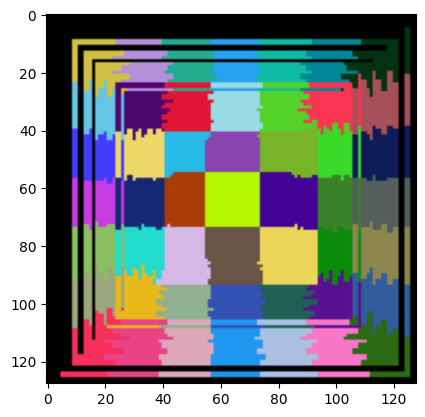

In [47]:
X_out, Y_out = get_FCG_mapping(nr=10,pmax=60,p0=20,c_gaze=(64,64),src_size=src.shape[:2])
recov = cv2.remap(fov,X_out,Y_out,
               interpolation=cv2.INTER_AREA,
               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
plt.imshow(recov)